
*******************************************
+ Name: weixiabing
+ Date: 9/20/22
********************************************


In [2]:
import dask.dataframe as dd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential,load_model
import cupy as cp
from keras.layers import LSTM
from  tensorflow.keras.layers import LSTM,Dense,Activation,Dropout
from  tensorflow.keras.callbacks import History,Callback,EarlyStopping
import os
testlist=dd.read_csv('D:\library\Github\Innovative-practice\library\csv\第三学期/testlist.csv')
trainlist=dd.read_csv('D:\library\Github\Innovative-practice\library\csv\第三学期/trainlist.csv')
testlist=cp.array(testlist)
trainlist=cp.array(trainlist)

In [3]:
def create_dataset(dataset, look_back):
#这里的look_back与timestep相同
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a[:,3])
        dataY.append(dataset[i + look_back,3])
    return cp.array(dataX),cp.array(dataY)
look_back = 25
trainX,trainY  = create_dataset(trainlist,look_back)
testX,testY = create_dataset(testlist,look_back)
trainX = cp.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = cp.reshape(testX, (testX.shape[0], testX.shape[1] ,1 ))
trainY = cp.reshape(trainY, (trainY.shape[0], 1))
testY = cp.reshape(testY, (testY.shape[0], 1))
print(trainX.shape)
print(trainY.shape)

(118974, 25, 1)
(118974, 1)


In [5]:
model = Sequential()
model.add(LSTM(80,input_shape=(trainX.shape[1],trainX.shape[2]),
                   return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(80,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(trainY.shape[1]))
model.add(Activation("relu"))

model.summary()

cbs = [History(), EarlyStopping(monitor='val_loss',
                                patience=10,
                                min_delta=0.00001,
                                verbose=0)]
model.compile(loss='mse',optimizer='adam')
model.fit(trainX.get(),
        trainY.get(),
        batch_size=64,
        epochs=200,
        validation_split=0.2,
        callbacks=cbs,
        verbose=True)
model.save(os.path.join("DATA","Test_lite" + ".h5"))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 25, 80)            26240     
                                                                 
 dropout_2 (Dropout)         (None, 25, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 80)                51520     
                                                                 
 dropout_3 (Dropout)         (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 81        
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 77,841
Trainable params: 77,841
Non-trai

In [6]:
model = load_model(os.path.join("DATA","Test_lite" + ".h5"))
trainPredict = model.predict(trainX.get())
testPredict = model.predict(testX[:].get())
print(trainPredict.shape)
print(testPredict.shape)



931/931 [==============================] - 3s 3ms/step
(118974, 1)
(29774, 1)


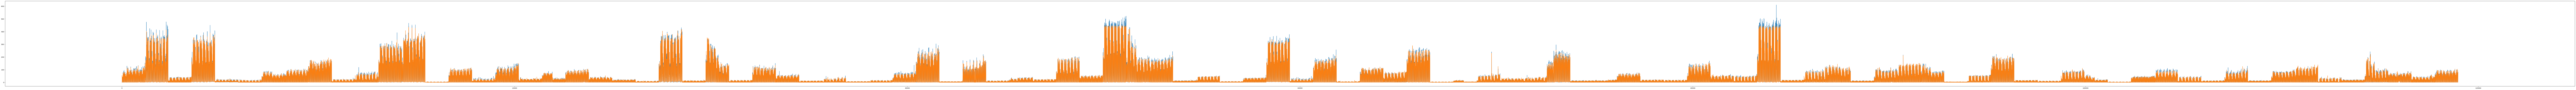

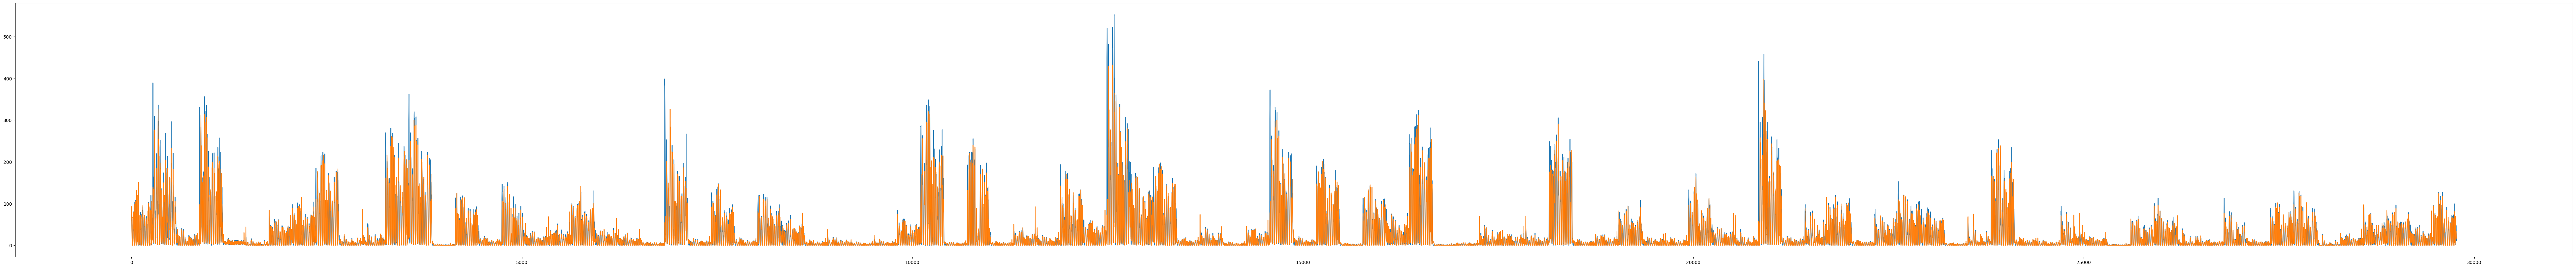

In [7]:
import matplotlib.pyplot as plt
plt.figure( figsize=(300,10) )
plt.plot(trainY.get())
plt.plot(trainPredict[1:])
plt.show()

plt.figure( figsize=(100,10) )
plt.plot(testY[:].get())
plt.plot(testPredict[1:])
plt.show()


In [9]:
from  sklearn import  metrics
import numpy as np

def GetRMSE(y_hat,y_test):
    sum = np.sqrt(metrics.mean_squared_error(y_test, y_hat))
    return  sum

def GetMAE(y_hat,y_test):
    sum = metrics.mean_absolute_error(y_test, y_hat)
    return  sum

def GetMAPE(y_hat,y_test):
    sum = np.mean(np.abs((y_hat - y_test) / y_test)) * 100
    return sum

def GetMAPE_Order(y_hat,y_test):
    #删除test_y 为0元素
    zero_index = np.where(y_test == 0)
    y_hat = np.delete(y_hat,zero_index[0])
    y_test = np.delete(y_test,zero_index[0])
    sum = np.mean(np.abs((y_hat - y_test) / y_test)) * 100
    return sum
#计算R2
def GetR2(y_hat,y_test):
    sum = metrics.r2_score(y_test, y_hat)
    return sum


print("RMSE为", GetRMSE(testY[:].get(), testPredict[:]))
print("MAE为", GetMAE(testY[:].get(), testPredict[:]))
print("MAPE为", GetMAPE_Order(testY[:].get(), testPredict[:]))
print("R2为", GetR2(testY[:].get(), testPredict[:]))


RMSE为 17.146670462468908
MAE为 5.369524395923022
MAPE为 115.69730946173595
R2为 0.8569778474215389
